# Continuous Control

---

This notebook presents the solution for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program, using a policy gradient method. The target is to train a 2 arm robot to reach and follow a moving target.

### 1. Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
# This enforces reloading of model.py or ddpg_agent.py in case they are changed

%load_ext autoreload
%autoreload 2

We should start the environment, but the `filename` must be set correctly according to the system that is used, i.e. 

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

I am running on Windows and the simulator is located in a directory called `Reacher_Windows_x86_64` in the same directory as the note boot. Consequently, my file name will be 

```
file_name="./Reacher_Windows_x86_64/Reacher.exe"
```

Also, the flag `no_graphics` allows to turn off the graphics and have a little bit faster execution.

```
env = UnityEnvironment(file_name="./Reacher_Windows_x86_64/Reacher.exe", no_graphics=True)
```

In [2]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name='./Reacher_Windows_x86_64/Reacher.exe', no_graphics=True)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Next, we investigate the environment.

In [3]:
# Following instructions, we we take the first brain available, and set it as 
# the default brain we will be controlling from Python.

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


I chose the second option, running 20 agents at the same time. Each agent is a double-jointed arm that has to move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. The goal for the agent is to maintain its position at the target location for as many time steps as possible and for each successful time step receive a reward of `+ 0.1`.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

### 2. Training

We are now ready to start the training. We rest the environment with `trainin_mode` set to `True`.

```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [4]:
import numpy as np
from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic

NOISE_DECAY = 1         # Noise decay rate - Added, but not used

from ddpg_agent import Agent
agent = Agent(state_size, action_size, LR_ACTOR, LR_CRITIC, BATCH_SIZE, BUFFER_SIZE, NOISE_DECAY, 13)

print("Actor network:", agent.actor_local)
print("Critic network:", agent.critic_local)

--- Using GPU ---
Actor network: Actor(
  (fc1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)
Critic network: Critic(
  (fcs1): Linear(in_features=33, out_features=128, bias=True)
  (fc2): Linear(in_features=132, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


Episode 0	Average 100 Score: 0.33	 Mean Score: 0.33
Episode 10	Average 100 Score: 0.79	 Mean Score: 1.39
Episode 20	Average 100 Score: 1.97	 Mean Score: 5.53
Episode 30	Average 100 Score: 3.83	 Mean Score: 9.52
Episode 40	Average 100 Score: 6.43	 Mean Score: 16.01
Episode 50	Average 100 Score: 10.49	 Mean Score: 34.39
Episode 60	Average 100 Score: 14.58	 Mean Score: 37.75
Episode 70	Average 100 Score: 17.56	 Mean Score: 35.67
Episode 80	Average 100 Score: 19.57	 Mean Score: 32.27
Episode 90	Average 100 Score: 21.29	 Mean Score: 37.45
Episode 100	Average 100 Score: 22.96	 Mean Score: 36.17
Episode 110	Average 100 Score: 26.38	 Mean Score: 34.75
Episode 120	Average 100 Score: 29.63	 Mean Score: 34.83
Episode 130	Average 100 Score: 32.36	 Mean Score: 34.90


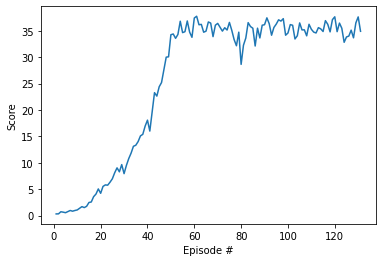

In [6]:
def ddpg(n_episodes=2000, max_t=2000):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(n_episodes):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        score = np.zeros(num_agents)
        step_counter = 0
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)
            
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished

            agent.step(states, actions, rewards, next_states, dones, GAMMA, TAU)

            states = next_states                               # roll over states to next time step
            score += rewards

            if np.any(dones):
                break 
        scores_deque.append(score)
        scores.append(np.mean(score))
        
        print('\rEpisode {}\tAverage 100 Score: {:.2f}\t Mean Score: {:.2f}'.format(i_episode, np.mean(scores_deque), np.mean(score)), end="")
        if i_episode % 10 == 0:
            agent.save_graphs()
            print('\rEpisode {}\tAverage 100 Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            if (np.mean(scores_deque) >= 31):
                break
    return scores

scores = ddpg(n_episodes=500)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


### 3. Testing

Now, we test the network by trying 10 times.


Episode 10	Average Score: 38.04	Score: 37.42

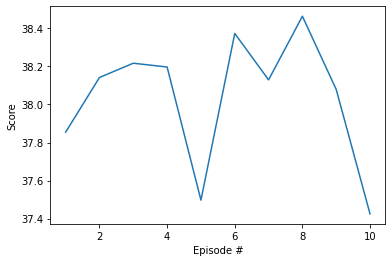

In [7]:
def ddpg_run(n_episodes=2, max_t=2000):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        score = np.zeros(num_agents)
        step_counter = 0
        for t in range(max_t):
            actions = agent.act(states, add_noise=False)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            states = next_states                               # roll over states to next time step
            score += rewards
            if np.any(dones):
                break 
        scores_deque.append(score)
        scores.append(np.mean(score))
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score.mean()), end="")
    return scores

scores = ddpg_run(n_episodes=10)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
        
env.close()